## Leitura e tratamento dos dados

### Importação de Bibliotecas

In [1]:
import pandas as pd
import gdown
import os
import matplotlib.pyplot as plt
import seaborn as sns

path_dados_vinho = "../../dados/vinho/"
path_dados_genericos = "../../dados/genericos/"

### Exportação

In [2]:
df_exp_espumantes = pd.read_csv(f"{path_dados_vinho}ExpEspumantes.csv", sep=";")
df_exp_suco = pd.read_csv(f"{path_dados_vinho}ExpSuco.csv", sep=";")
df_exp_uva = pd.read_csv(f"{path_dados_vinho}ExpUva.csv", sep=";")
df_exp_vinho = pd.read_csv(f"{path_dados_vinho}ExpVinho.csv", sep=";")

# Derretendo o DataFrame de Exportação de vinhos para ter uma linha para cada ano
df_exp_vinho_melted = pd.melt(df_exp_vinho, id_vars=['Id', 'País'], var_name='Ano_Metrica', value_name='Valor')

# Separando o Ano e a Métrica (Quantidade_kg ou Valor_Us) em colunas separadas
df_exp_vinho_melted[['Ano', 'Metrica']] = df_exp_vinho_melted['Ano_Metrica'].str.extract('(\d+)(\.\d+)?')

# Criando um DataFrame separado para Quantidade_kg e Valor_Us
df_quantidade_exp = df_exp_vinho_melted[df_exp_vinho_melted['Metrica'].isna()].drop(columns='Metrica').rename(columns={'Valor': 'Quantidade_kg'})
df_valor_exp = df_exp_vinho_melted[df_exp_vinho_melted['Metrica'].notna()].drop(columns='Metrica').rename(columns={'Valor': 'Valor_us'})

# Mesclando os DataFrames de Quantidade_kg e Valor_Us com base no Id, País e Ano
df_exp_vinhos_final = pd.merge(df_quantidade_exp, df_valor_exp, on=['Id', 'País', 'Ano'])

# Reordenando/Renomeando as colunas
df_exp_vinhos_final = df_exp_vinhos_final[['Id', 'País', 'Ano', 'Quantidade_kg', 'Valor_us']]

# Filtrando apenas os últimos 15 anos
df_exp_vinhos_final['Ano'] = df_exp_vinhos_final['Ano'].astype(int)
df_exp_vinhos_final_ultimos_quinze_anos = df_exp_vinhos_final.query('Ano >= 2008')

# Função para identificar os 10 principais países por métrica
def filter_top_10(df, metric):
    top_10_countries = df.groupby('País')[metric].sum().nlargest(10, 'all').index
    return df[df['País'].isin(top_10_countries)]

# Filtrando para os 10 principais países para cada métrica
df_top_10_quantidade_exp = filter_top_10(df_exp_vinhos_final_ultimos_quinze_anos, 'Quantidade_kg')
df_top_10_valor_exp = filter_top_10(df_exp_vinhos_final_ultimos_quinze_anos, 'Valor_us')

### Comércio

In [3]:
df_comercio = pd.read_csv(f"{path_dados_vinho}Comercio.csv", sep=";", header=None)

# Mantendo apenas as colunas ID, Categoria, Subcategoria para os últimos 15 anos.
df_comercio.columns = ['ID', 'Categoria', 'Subcategoria'] + [str(ano) for ano in range(1970, 2022)]

# Função para tratar as categorias
def categorizar(cat):
    mappings = {
        'vm': 'VINHO DE MESA',
        've': 'VINHO ESPECIAL',
        'es': 'ESPUMANTES',
        'su': 'SUCO DE UVAS',
        'ou': 'OUTROS PRODUTOS COMERCIALIZADOS'
    }
    prefixo = cat.split('_')[0]  # Obtém apenas o prefixo (primeira parte antes do "_")
    return mappings.get(prefixo, prefixo)  # Retorna o valor mapeado, ou o prefixo original se não estiver no mapeamento

df_comercio['Categoria'] = df_comercio['Categoria'].apply(categorizar)

# Filtrando apenas os dados de comércio de vinhos por categoria
df_comercio_vinhos = df_comercio.query("(Categoria == Subcategoria & Categoria.str.contains('VINHO')) | Categoria == 'OUTROS PRODUTOS COMERCIALIZADOS' & Subcategoria.str.contains('Vinho')")

# Filtrando apenas os últimos 15 anos
filtro_ultimos_quinze_anos = ['ID', 'Categoria', 'Subcategoria'] + [str(ano) for ano in range(2008, 2022)]
df_comercio_vinhos_ultimos_quinze_anos = df_comercio_vinhos[filtro_ultimos_quinze_anos]

# Realizando o melt para transformar a coluna anos em linhas
df_comercio_vinhos_melted = df_comercio_vinhos_ultimos_quinze_anos.melt(id_vars=['ID', 'Categoria', 'Subcategoria'], 
                                            var_name='Ano', 
                                            value_name='Valor')

# Organizando o DataFrame para uma melhor visualização
df_comercio_vinhos_melted.sort_values(by=['ID', 'Ano'], inplace=True)
df_comercio_vinhos_melted.reset_index(drop=True, inplace=True)


### Importação

In [4]:
df_imp_espumantes = pd.read_csv(f"{path_dados_vinho}ImpEspumantes.csv", sep=";")
df_imp_frescas = pd.read_csv(f"{path_dados_vinho}ImpFrescas.csv", sep=";")
df_imp_passas = pd.read_csv(f"{path_dados_vinho}ImpPassas.csv", sep=";")
df_imp_suco = pd.read_csv(f"{path_dados_vinho}ImpSuco.csv", sep=";")
df_imp_vinhos = pd.read_csv(f"{path_dados_vinho}ImpVinhos.csv", sep=";")


# Derretendo o DataFrame de Importação de Vinhos para ter uma linha para cada ano
df_imp_vinhos_melted = pd.melt(df_imp_vinhos, id_vars=['Id', 'País'], var_name='Ano_Metrica', value_name='Valor')

# Separando o Ano e a Métrica (Quantidade_kg ou Valor_Us) em colunas separadas
df_imp_vinhos_melted[['Ano', 'Metrica']] = df_imp_vinhos_melted['Ano_Metrica'].str.extract('(\d+)(\.\d+)?')

# Criando um DataFrame separado para Quantidade_kg e Valor_Us
df_quantidade_imp = df_imp_vinhos_melted[df_imp_vinhos_melted['Metrica'].isna()].drop(columns='Metrica').rename(columns={'Valor': 'Quantidade_kg'})
df_valor_imp = df_imp_vinhos_melted[df_imp_vinhos_melted['Metrica'].notna()].drop(columns='Metrica').rename(columns={'Valor': 'Valor_us'})

# Mesclando os DataFrames de Quantidade_kg e Valor_Us com base no Id, País e Ano
df_imp_vinhos_final = pd.merge(df_quantidade_imp, df_valor_imp, on=['Id', 'País', 'Ano'])

# Reordenando/Renomeando as colunas
df_imp_vinhos_final = df_imp_vinhos_final[['Id', 'País', 'Ano', 'Quantidade_kg', 'Valor_us']]

# Filtrando apenas os últimos 15 anos
df_imp_vinhos_final['Ano'] = df_imp_vinhos_final['Ano'].astype(int)
df_imp_vinhos_final_ultimos_quinze_anos = df_imp_vinhos_final.query('Ano >= 2008')

# Função para identificar os 10 principais países por métrica
def filter_top_10(df, metric):
    top_10_countries = df.groupby('País')[metric].sum().nlargest(10, 'all').index
    return df[df['País'].isin(top_10_countries)]

# Filtrando para os 10 principais países para cada métrica
df_top_10_quantidade_imp = filter_top_10(df_imp_vinhos_final_ultimos_quinze_anos, 'Quantidade_kg')
df_top_10_valor_imp = filter_top_10(df_imp_vinhos_final_ultimos_quinze_anos, 'Valor_us')


### Processamento

In [5]:
df_proc_americanas = pd.read_csv(f"{path_dados_vinho}ProcessaAmericanas.csv", sep=";")
df_proc_mesa = pd.read_csv(f"{path_dados_vinho}ProcessaMesa.csv", sep=";")
df_proc_viniferas = pd.read_csv(f"{path_dados_vinho}ProcessaViniferas.csv", sep="\t")

# Filtrando dos dados de processamento apenas os valores absolutos por categoria de  vinhos
df_proc_viniferas_categorias = df_proc_viniferas.query('(cultivar == "TINTAS") | (cultivar == "BRANCAS E ROSADAS")').head()

# Dropando coluna redundante "control"
df_proc_viniferas_categorias.drop(columns = 'control', axis=1, inplace=True)

# Derretendo o dataframe para transformar anos em linhas
df_proc_viniferas_categorias_melted = pd.melt(df_proc_viniferas_categorias, id_vars=['id', 'cultivar'], var_name = 'Ano', value_name = 'Quantidade_litros')

# Transformando a coluna Ano em int para filtrar os últimso 15 anos
df_proc_viniferas_categorias_melted.Ano = df_proc_viniferas_categorias_melted.Ano.astype(int)
df_proc_viniferas_categorias_ultimos_quinze_anos = df_proc_viniferas_categorias_melted.query('Ano >= 2008')

# Tratando valores nulos
df_proc_viniferas_categorias_ultimos_quinze_anos['Quantidade_litros'] = df_proc_viniferas_categorias_ultimos_quinze_anos['Quantidade_litros'].replace('nd', '0')

# Transformando a coluna de volta para inteiro
df_proc_viniferas_categorias_ultimos_quinze_anos.Quantidade_litros = df_proc_viniferas_categorias_ultimos_quinze_anos.Quantidade_litros.astype(int)



C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_22332\628428601.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proc_viniferas_categorias_ultimos_quinze_anos['Quantidade_litros'] = df_proc_viniferas_categorias_ultimos_quinze_anos['Quantidade_litros'].replace('nd', '0')
C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_22332\628428601.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proc_viniferas_categorias_ultimos_quinze_anos.Quantidade_litros = df_proc_viniferas_categorias_ultimos_q

### Produção

In [6]:
df_produção = pd.read_csv(f"{path_dados_vinho}Producao.csv", sep=";")

# Filtrando dos dados de producao apenas Vinhos
df_producao_vinhos = df_produção.query("produto.str.contains('VINHO') | produto.str.contains('Vinho')" )

# Derretendo o dataframe para considerar as colunas de Ano como Linhas
df_producao_vinhos = df_producao_vinhosmelted = pd.melt(df_producao_vinhos, id_vars=['id', 'produto'], var_name='Ano', value_name='Quantidade_litros')

# Modificando o type da coluna Ano para inteiro para filtrar os últimos 15 anos
df_producao_vinhos.Ano = df_producao_vinhos.Ano.astype('int')
df_producao_vinhos_ultimos_quinze_anos = df_producao_vinhos.query('Ano >= 2008')


### Temperatura

In [6]:
FILE_ID = '1-hO1qJ3e90VCRy-u67F-u_wT4lKuym2j'
filename = 'city_temperature.csv'
output = os.path.join(path_dados_genericos, filename)

if not os.path.exists(output):
    url = f'https://drive.google.com/uc?id={FILE_ID}'
    gdown.download(url, output, quiet=False)
else:
    print("O arquivo já existe.")

df_temperaturas = pd.read_csv(f"{path_dados_genericos}city_temperature.csv", sep=",", low_memory=False)
df_temperaturas = df_temperaturas[['Country', 'Year', 'AvgTemperature']]
df_temperaturas = df_temperaturas.groupby(['Country', 'Year'], as_index=False).agg({'AvgTemperature': 'mean'})
df_temperaturas['AvgTemperature'] = (df_temperaturas['AvgTemperature'] - 32) * 5/9
df_temperaturas = df_temperaturas.query('Year >= 2007')

O arquivo já existe.


,Country,Year,AvgTemperature
12,Albania,2007,16.050076
13,Albania,2008,15.439284
14,Albania,2009,15.222831
15,Albania,2010,15.871537
16,Albania,2011,15.510350


### Expectativa de vida

In [4]:
df_expectativa_vida = pd.read_csv(f"{path_dados_genericos}life_expectancy_data.csv", sep=",")

## Construção das tabelas

### Exportação

In [7]:
df_exp_espumantes_melted = df_exp_espumantes.melt(id_vars=["Id", "País"], var_name="ano", value_name="valor")
df_exp_espumantes_melted["categoria"] = "Bebida"
df_exp_espumantes_melted["subcategoria"] = "Espumante"

df_exp_suco_melted = df_exp_suco.melt(id_vars=["Id", "País"], var_name="ano", value_name="valor")
df_exp_suco_melted["categoria"] = "Bebida"
df_exp_suco_melted["subcategoria"] = "Suco"

df_exp_uva_melted = df_exp_uva.melt(id_vars=["Id", "País"], var_name="ano", value_name="valor")
df_exp_uva_melted["categoria"] = "Fruta"
df_exp_uva_melted["subcategoria"] = "Uva"

df_exp_vinho_melted = df_exp_vinho.melt(id_vars=["Id", "País"], var_name="ano", value_name="valor")
df_exp_vinho_melted["categoria"] = "Bebida"
df_exp_vinho_melted["subcategoria"] = "Vinho"

df_exportacao_total = pd.concat([df_exp_espumantes_melted, df_exp_suco_melted, df_exp_uva_melted, df_exp_vinho_melted], ignore_index=True)

df_exportacao_total['ano'] = df_exportacao_total['ano'].astype(str)

df_exportacao_total['ano'] = df_exportacao_total['ano'].str.split('.').str[0]

df_exportacao_total['ano'] = df_exportacao_total['ano'].astype(int)

## Visualização de Dados

### Evolução da Importação de vinhos dos top 10 países últimos 15 anos

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_22332\2085556702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10_quantidade_imp['Ano'] = df_top_10_quantidade_imp['Ano'].astype(str)
C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_22332\2085556702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10_valor_imp['Ano'] = df_top_10_valor_imp['Ano'].astype(str)


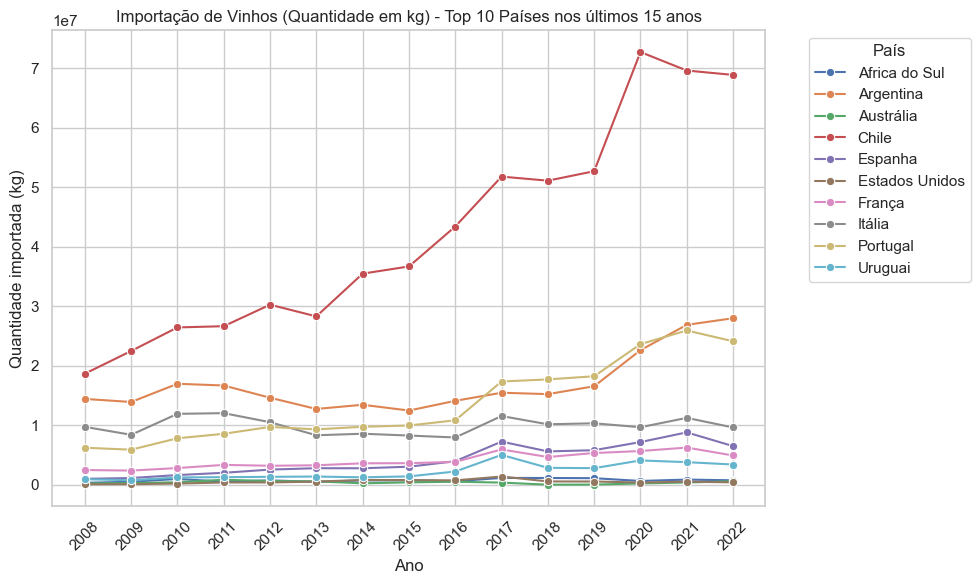

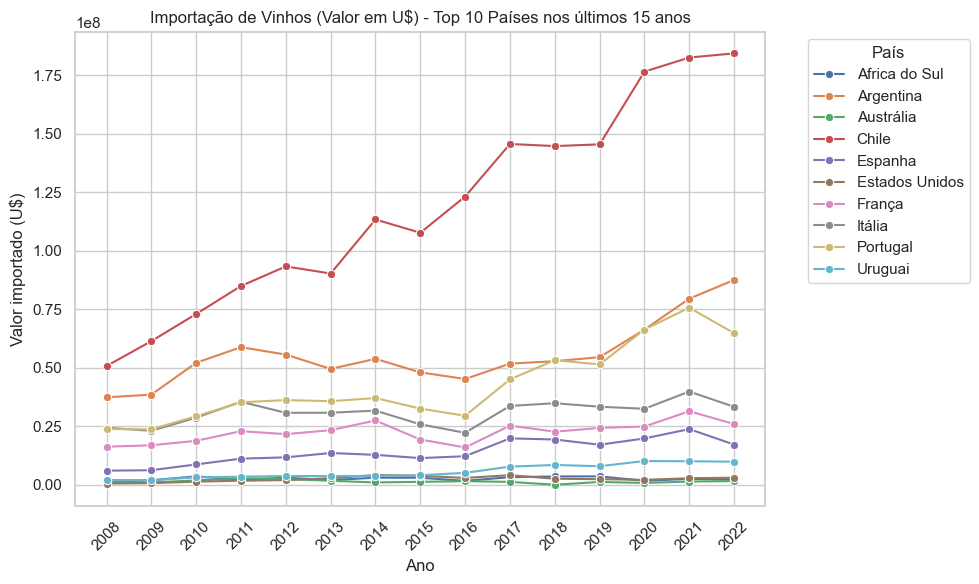

In [8]:
# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Mudando o type da coluna Ano para STR para aparecer todos os ticks
df_top_10_quantidade_imp['Ano'] = df_top_10_quantidade_imp['Ano'].astype(str)
df_top_10_valor_imp['Ano'] = df_top_10_valor_imp['Ano'].astype(str)

# Criando o gráfico para Quantidade_kg
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_top_10_quantidade_imp, x='Ano', y='Quantidade_kg', hue='País', marker="o")
plt.title('Importação de Vinhos (Quantidade em kg) - Top 10 Países nos últimos 15 anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade importada (kg)')
plt.xticks(rotation=45)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Criando o gráfico para Valor_Us
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_top_10_valor_imp, x='Ano', y='Valor_us', hue='País', marker="o")
plt.title('Importação de Vinhos (Valor em U$) - Top 10 Países nos últimos 15 anos')
plt.xlabel('Ano')
plt.ylabel('Valor importado (U$)')
plt.xticks(rotation=45)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Evolução do Comércio de vinhos por categoria nos últimos 15 anos

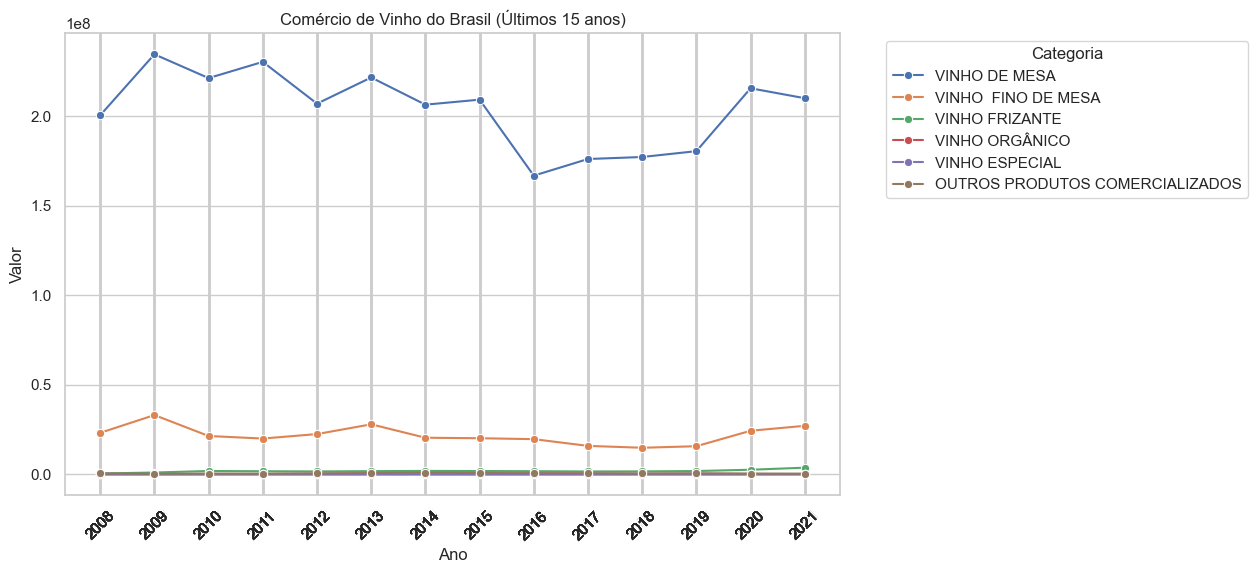

In [9]:
# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_comercio_vinhos_melted, x='Ano', y='Valor', hue='Categoria', marker="o")

# Especificando título, labels, ticks e legenda.
plt.title('Comércio de Vinho do Brasil (Últimos 15 anos)')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=df_comercio_vinhos_melted['Ano'], labels=df_comercio_vinhos_melted['Ano'])

plt.show()

### Evolução da Exportação de vinhos dos top 10 países dos últimos 15 anos

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_22332\1356709900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10_quantidade_exp['Ano'] = df_top_10_quantidade_exp['Ano'].astype(str)
C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_22332\1356709900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10_valor_exp['Ano'] = df_top_10_valor_exp['Ano'].astype(str)


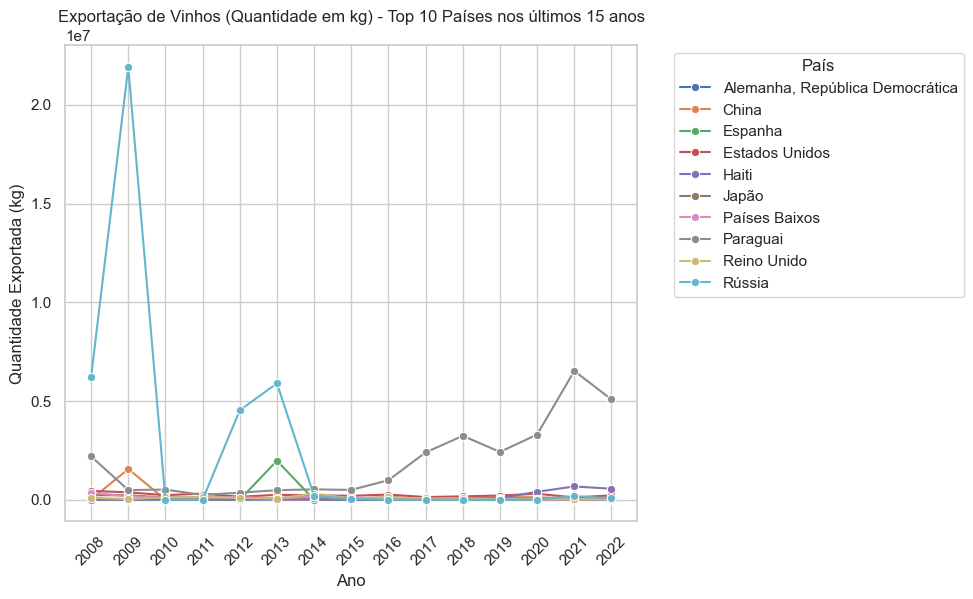

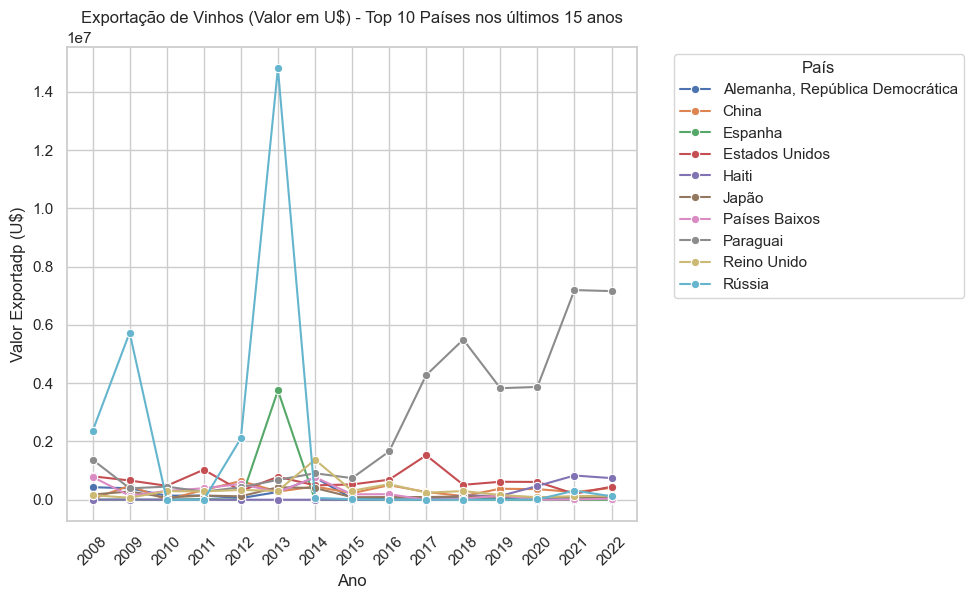

In [10]:
# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Mudando o type da coluna Ano para STR para aparecer todos os ticks
df_top_10_quantidade_exp['Ano'] = df_top_10_quantidade_exp['Ano'].astype(str)
df_top_10_valor_exp['Ano'] = df_top_10_valor_exp['Ano'].astype(str)

# Criando o gráfico para Quantidade_kg
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_top_10_quantidade_exp, x='Ano', y='Quantidade_kg', hue='País', marker="o")
plt.title('Exportação de Vinhos (Quantidade em kg) - Top 10 Países nos últimos 15 anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade Exportada (kg)')
plt.xticks(rotation=45)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Criando o gráfico para Valor_Us
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_top_10_valor_exp, x='Ano', y='Valor_us', hue='País', marker="o")
plt.title('Exportação de Vinhos (Valor em U$) - Top 10 Países nos últimos 15 anos')
plt.xlabel('Ano')
plt.ylabel('Valor Exportadp (U$)')
plt.xticks(rotation=45)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Evolução da Produção de vinhos nos últimos 15 anos

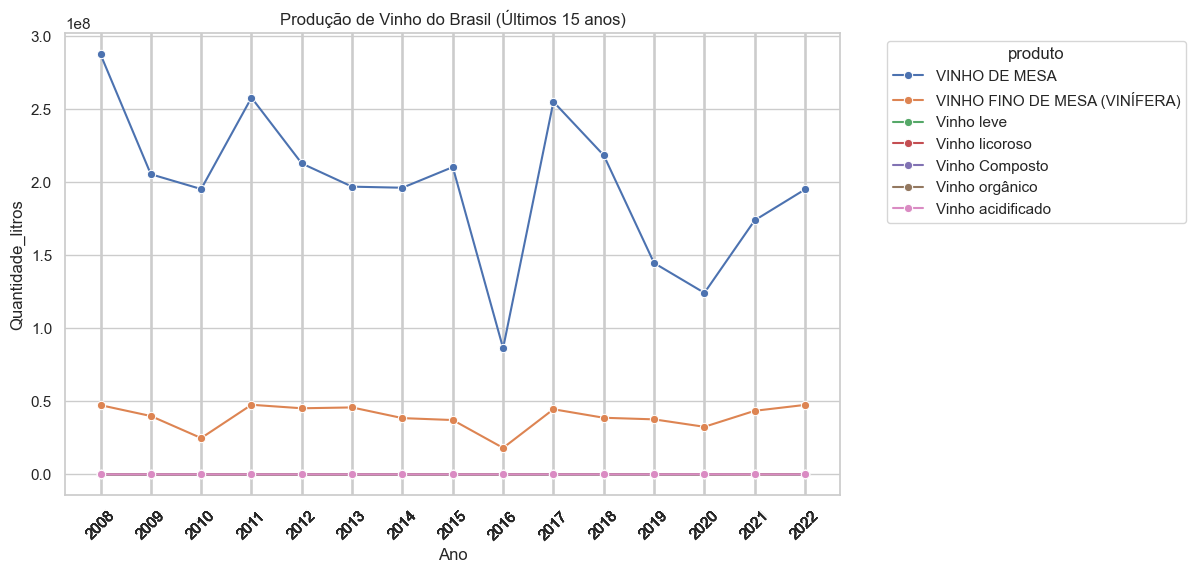

In [11]:
# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Mudando o type da coluna Ano para STR
df_producao_vinhos_ultimos_quinze_anos.Ano.astype(str)

# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_producao_vinhos_ultimos_quinze_anos, x='Ano', y='Quantidade_litros', hue='produto', marker="o")

# Especificando título, labels, ticks e legenda.
plt.title('Produção de Vinho do Brasil (Últimos 15 anos)')
plt.xlabel('Ano')
plt.ylabel('Quantidade_litros')
plt.xticks(rotation=45)
plt.legend(title='produto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=df_producao_vinhos_ultimos_quinze_anos['Ano'], labels=df_producao_vinhos_ultimos_quinze_anos['Ano'])

plt.show()

### Evolução no Processamento de vinhos últimos 15 anos

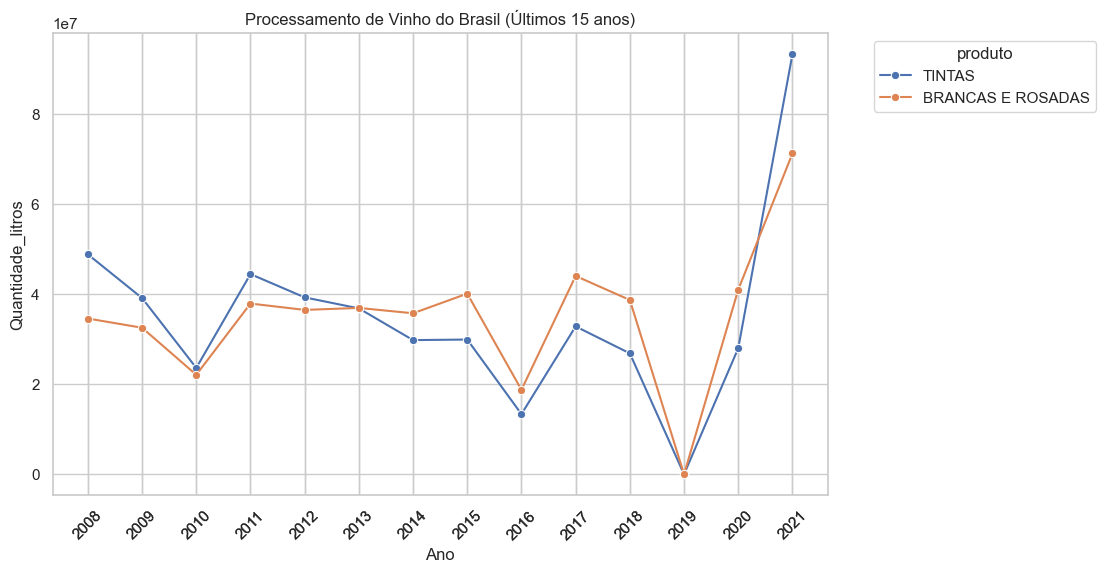

In [19]:
# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")

# Mudando o type da coluna Ano para STR
df_proc_viniferas_categorias_ultimos_quinze_anos.Ano.astype(str)

# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_proc_viniferas_categorias_ultimos_quinze_anos, x='Ano', y='Quantidade_litros', hue='cultivar', marker="o")

# Especificando título, labels, ticks e legenda.
plt.title('Processamento de Vinho do Brasil (Últimos 15 anos)')
plt.xlabel('Ano')
plt.ylabel('Quantidade_litros')
plt.xticks(rotation=45)
plt.legend(title='produto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=df_proc_viniferas_categorias_ultimos_quinze_anos['Ano'], labels=df_proc_viniferas_categorias_ultimos_quinze_anos['Ano'])

plt.show()

### Exportação

In [13]:
df_ultimos_15_anos = df_exportacao_total[df_exportacao_total['ano'] >= 2007]

#### Evolução das Exportações ao Longo do Tempo:
Este gráfico de linhas mostra como as exportações totais mudaram ano a ano nos últimos 15 anos. Cada ponto na linha representa o valor total exportado em um ano específico, e a linha conecta esses pontos para mostrar a tendência ao longo do tempo. Este gráfico ajuda a identificar padrões ou anomalias nas exportações ao longo dos anos e pode ser útil para entender se existe uma tendência de crescimento, declínio ou estabilidade nas exportações.

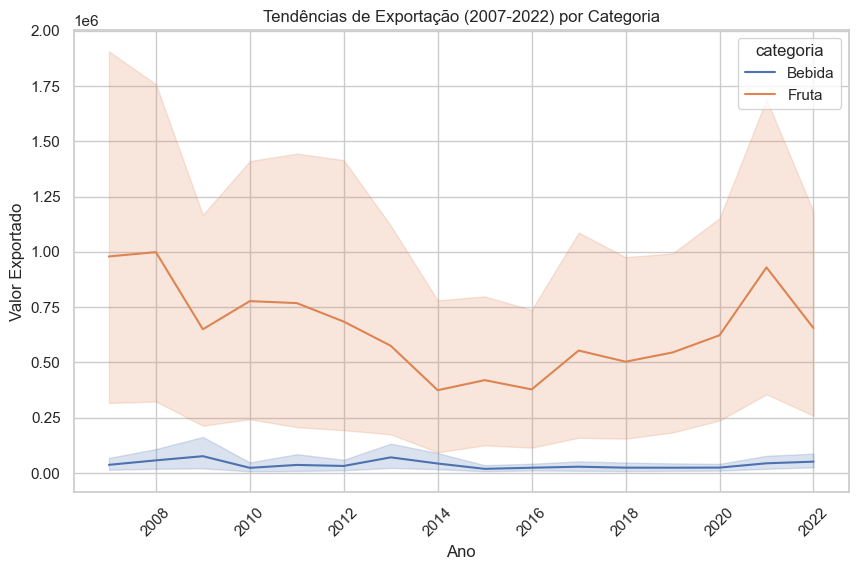

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_ultimos_15_anos, x="ano", y="valor", hue="categoria")
plt.title('Tendências de Exportação (2007-2022) por Categoria')
plt.ylabel('Valor Exportado')
plt.xlabel('Ano')
plt.xticks(rotation=45)
plt.show()


#### Distribuição de Exportações por País Destino (2007-2022) - Top 10 Países
Este gráfico de barras exibe os dez países para os quais o Brasil mais exportou nos últimos 15 anos. O eixo X mostra os países, e o eixo Y mostra o valor total exportado para cada país. As barras são proporcionais aos valores exportados. Este gráfico é útil para identificar os principais destinos das exportações brasileiras e entender quais países têm a maior participação no mercado de exportação.

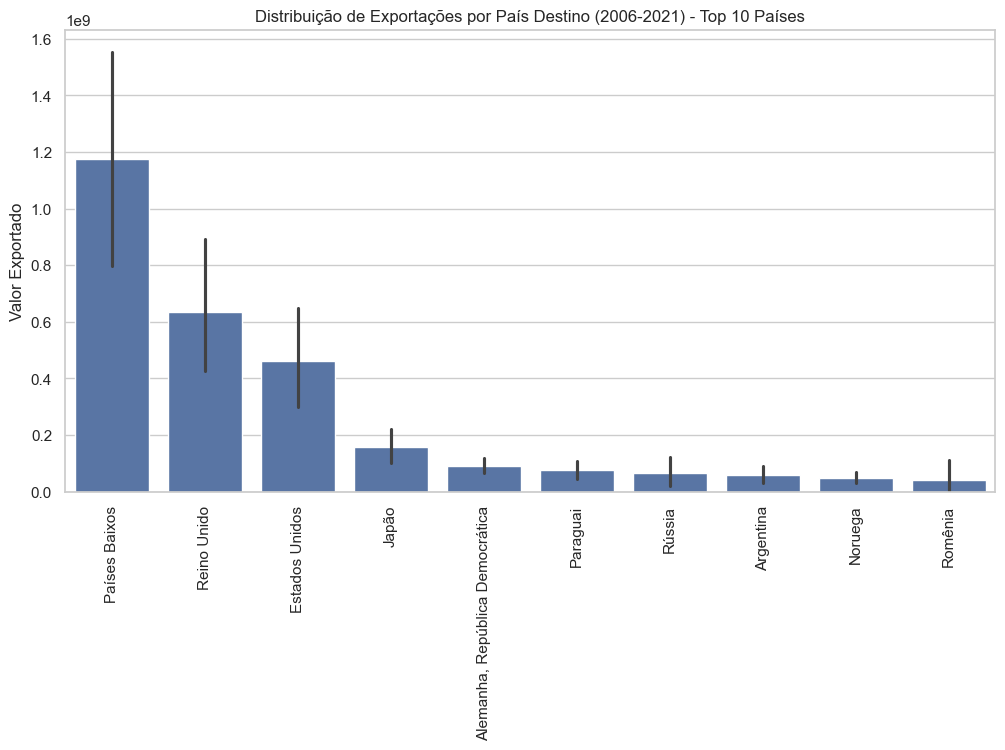

In [15]:
df_soma_por_pais = df_ultimos_15_anos.groupby('País')['valor'].sum().reset_index()

top_10_paises = df_soma_por_pais.sort_values(by='valor', ascending=False).head(10)

df_top_10_paises = df_ultimos_15_anos[df_ultimos_15_anos['País'].isin(top_10_paises['País'])]

plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_10_paises, x="País", y="valor", estimator=sum, order=top_10_paises['País'])
plt.title('Distribuição de Exportações por País Destino (2006-2021) - Top 10 Países')
plt.ylabel('Valor Exportado')
plt.xlabel('')
plt.xticks(rotation=90)
plt.show()


#### Proporção de Exportações por Categoria de Produto (2007-2022):
Este gráfico de pizza mostra a proporção do valor total exportado atribuída a cada categoria de produto nos últimos 15 anos. Cada fatia da pizza representa uma categoria de produto, e o tamanho da fatia é proporcional ao valor total exportado para essa categoria. As porcentagens em cada fatia indicam a participação de cada categoria no total de exportações. Este gráfico ajuda a visualizar rapidamente quais categorias são mais significativas em termos de valor exportado.

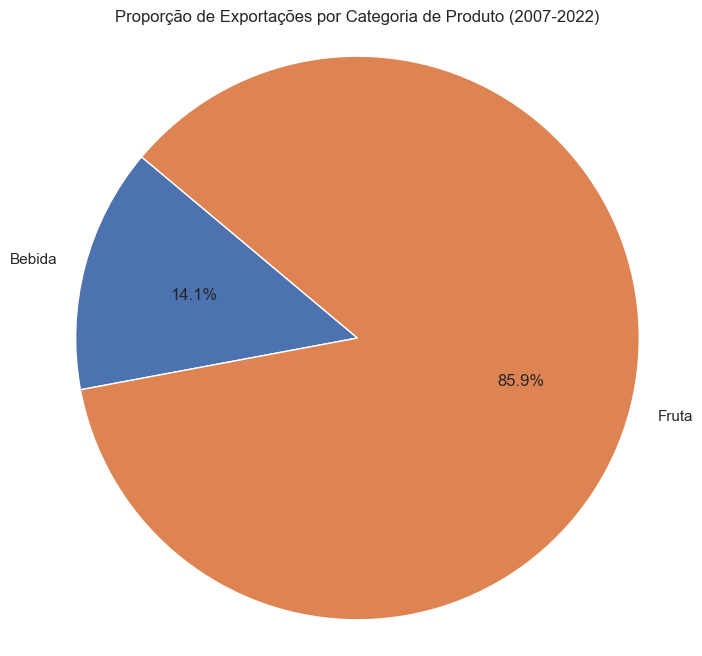

In [16]:
df_soma_por_categoria = df_ultimos_15_anos.groupby('categoria')['valor'].sum()

plt.figure(figsize=(8, 8))
plt.pie(df_soma_por_categoria, labels=df_soma_por_categoria.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title('Proporção de Exportações por Categoria de Produto (2007-2022)')
plt.show()

#### Correlação entre Anos e Valores Exportados:
Este mapa de calor mostra a correlação entre diferentes variáveis no dataframe. Cada célula no mapa de calor representa a correlação entre duas variáveis, e a cor da célula indica a força e a direção da correlação (cores mais quentes indicam correlação positiva, cores mais frias indicam correlação negativa). Este gráfico é útil para identificar relações entre diferentes variáveis e pode ajudar a entender quais fatores estão mais fortemente associados a valores de exportação mais altos ou mais baixos.

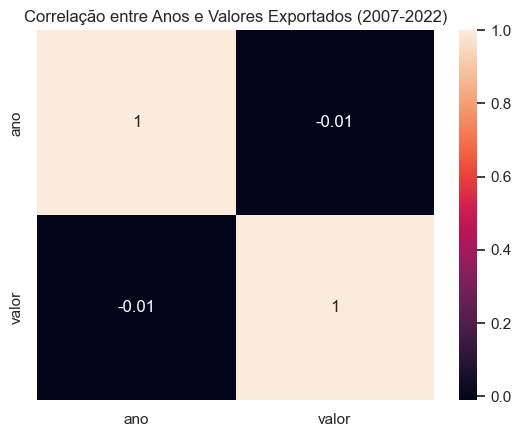

In [17]:
corr_matrix = df_ultimos_15_anos[['ano', 'valor']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlação entre Anos e Valores Exportados (2007-2022)')
plt.show()

Análise Estatística Descritiva:

In [18]:
desc_stats = df_ultimos_15_anos['valor'].describe()
print(desc_stats)

count    1.526400e+04
mean     2.017032e+05
std      2.304413e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.500000e+02
max      8.097690e+07
Name: valor, dtype: float64
